# Step 1: Import necessary packages

In [2]:
pip install torch pandas numpy sentencepiece nltk gensim beautifulsoup4 scikit-learn joblib tqdm matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import numpy as np
import sentencepiece as spm
import re
from bs4 import BeautifulSoup
import unicodedata
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_recall_fscore_support,
    accuracy_score,
    roc_auc_score,
    confusion_matrix
)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import sys
import random
import json
import time
import itertools
import hashlib
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# PyTorch (CPU & CUDA)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if multi-GPU

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [93]:
g = torch.Generator()
g.manual_seed(SEED)

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
print("ROOT_DIR =", ROOT_DIR)  # should be .../dsa4213
sys.path.append(ROOT_DIR)

# set file paths and import necessary things
from Features.encoding.bilstm_pipeline.biLSTM import BiLSTMClassifier
best_dir_path = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "best_ckpts")
best_pt_path = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "best_ckpts", "best.pt")
manifest_path = os.path.join(best_dir_path, "manifest.json")
with open(manifest_path, "r") as f:
    mf = json.load(f)

best_ckpt = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "best_ckpts")
sp_model_path  = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "embedder_files", "email_sp.model")
embed_matrix_path = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "best_ckpts", "embedding_matrix.npy")
test_data_path = os.path.join(ROOT_DIR, "datasets", "encoder_dataset", "clean", "bilstm", "encoder_test_clean.csv")
cd_path = os.path.join(ROOT_DIR, "datasets", "cross_domain_dataset", "clean", "bilstm", "cross_domain_clean.csv")


ROOT_DIR = /Users/subhashree/Desktop/dsa4213


# Step 2: Reload BiLSTM models

## Helper functions

In [86]:
# helpers
def vocab_to_id_mapper(
        input_df
        ,max_len
        ,sp
) :
    
    pad_id = sp.piece_to_id("<pad>")
    if pad_id == -1:  
        pad_id = 0

    
    def encode_ids(text) :
        if not isinstance(text, str):
            text = "" if pd.isna(text) else str(text)
        return sp.encode_as_ids(text)

    def pad_ids(ids,max_len,pad_id) -> np.ndarray:
        if len(ids) >= max_len:
            return np.array(ids[:max_len], dtype=np.int32)
        return np.array(ids + [pad_id] * (max_len - len(ids)), dtype=np.int32)

    
    df = input_df.copy()
    df["sp_ids"] = df["Body"].apply(encode_ids)

    # overwrite sp_ids_padded with NumPy arrays directly
    df["sp_ids_padded"] = df["sp_ids"].apply(lambda ids: pad_ids(ids, max_len, pad_id))

    return df

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def df_to_ids_and_labels(df):
    # 'sp_ids_padded' should be a list/array per row; stack to [N, max_len]
    X_ids = np.stack(df["sp_ids_padded"].values).astype(np.int64)
    y = df["label"].astype(np.int64).values
    return X_ids, y

def make_loader(X_ids, y, batch_size=128, shuffle=False):
    X = torch.tensor(X_ids, dtype=torch.long)
    y = torch.tensor(y,     dtype=torch.long)
    ds = TensorDataset(X, y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

@torch.no_grad()
def extract_features(encoder, dl, device):
    encoder.eval()
    feats, labels = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        z  = encoder(xb)                                # [B, feat_dim] (e.g., 512)
        feats.append(z.cpu().numpy().astype(np.float32))
        labels.append(yb.numpy().astype(np.int64))
    return np.concatenate(feats), np.concatenate(labels)


class TextDS(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(np.stack(X), dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

## Reload base model

### Test set data tokenisation

In [87]:
with open(best_dir_path+'/manifest.json','r') as f:
    mf = json.load(f)

pad_id       = int(mf["pad_id"])
max_len      = int(mf["max_len"])
hidden_dim   = int(mf["hidden_dim"])
num_layers   = int(mf["num_layers"])
bidirectional= bool(mf["bidirectional"])
num_classes  = int(mf["num_classes"])
droupout     = float(mf['dropout'])
weight_decay = float(mf['weight_decay'])
best_thr = float(mf['val_threshold'])

In [88]:
# reload embedding matrix and sp process for tokenisation of test set
sp = spm.SentencePieceProcessor()
sp.load(sp_model_path)
embedding_matrix = np.load(embed_matrix_path)


In [89]:
print(embedding_matrix.shape)
print(sp.get_piece_size())

(50000, 300)
50000


In [90]:
test_df = pd.read_csv(test_data_path)

test_df.rename(columns = {'text_combined':'Body'},inplace=True)
test_df = vocab_to_id_mapper(test_df,256,sp)
test_ds  = TextDS(test_df['sp_ids_padded'].values, test_df['label'].values)
assert test_df['sp_ids_padded'].apply(len).eq(256).all()
test_dl  = DataLoader(test_ds, batch_size=128, shuffle=False,
                      num_workers=0, pin_memory=True,
                      worker_init_fn=seed_worker, generator=g)

In [95]:
# rebuild model using manifest config
model = BiLSTMClassifier(
    embedding_matrix=embedding_matrix,
    pad_id=pad_id,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=droupout,
    bidirectional=bidirectional,
    num_classes=num_classes,
).to(device)

# load checkpoints
ckpt = torch.load(best_pt_path, map_location=device)
model.load_state_dict(ckpt["model"], strict=True)
model.eval()

print(f"Model reloaded successfully onto device {device}")
print(f"Loaded epoch: {ckpt.get('epoch', '?')} | Best F1: {ckpt.get('best_val_f1', '?'):.4f}")
print(" Model Architecture Summary")
print("=" * 40)
print(f"Model Type      : {model.__class__.__name__}")
print(f"Hidden Dim      : {hidden_dim}")
print(f"Num Layers      : {num_layers}")
print(f"Bidirectional   : {bidirectional}")
print(f"Dropout         : {droupout}")
print(f"Embedding Dim   : {embedding_matrix.shape[1]}")
print(f"Vocab Size      : {embedding_matrix.shape[0]}")
print(f"Output Classes  : {num_classes}")
print("=" * 40)
print(f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable Params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print("=" * 40)

INFO:Features.encoding.bilstm_pipeline.biLSTM:BiLSTM Encoder initialized | emb_dim=300, hidden_dim=256, layers=2, bidirectional=True, freeze_embeddings=True


Model reloaded successfully onto device cpu
Loaded epoch: 10 | Best F1: 0.9899
 Model Architecture Summary
Model Type      : BiLSTMClassifier
Hidden Dim      : 256
Num Layers      : 2
Bidirectional   : True
Dropout         : 0.5
Embedding Dim   : 300
Vocab Size      : 50000
Output Classes  : 2
Total Parameters: 17,721,794
Trainable Params: 2,721,794


## Reload ablation model

In [96]:
with open(best_dir_path+'/meta.json', "r") as f:
    meta = json.load(f)
val_thr   = float(meta["val_threshold"])
feat_dim  = int(meta["feat_dim"])

In [98]:
abl_model = BiLSTMClassifier(
    embedding_matrix=embedding_matrix,
    pad_id=pad_id,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=droupout,
    bidirectional=bidirectional,
    num_classes=num_classes,
).to(device)

# load checkpoint
ckpt = torch.load(best_pt_path, map_location=device)
abl_model.load_state_dict(ckpt["model"], strict=True)
abl_model.eval()
encoder = abl_model.encoder
encoder.eval()


hgb = joblib.load(best_dir_path+'/model.pkl')
print("HistGB classifier head loaded")

INFO:Features.encoding.bilstm_pipeline.biLSTM:BiLSTM Encoder initialized | emb_dim=300, hidden_dim=256, layers=2, bidirectional=True, freeze_embeddings=True


HistGB classifier head loaded


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to u

### Test data tokenisation

In [99]:
# test_df is from upstream
Xte_ids, yte = df_to_ids_and_labels(test_df)
abl_test_dl  = make_loader(Xte_ids, yte, batch_size=128, shuffle=False)
X_te, y_te = extract_features(encoder, test_dl,  device)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [100]:
assert X_te.shape[1] == feat_dim, f"feat dim mismatch: {X_te.shape[1]} vs meta {feat_dim}"
print("Features:", X_te.shape)

Features: (8056, 512)


# Step 3: Evaluation

### Base Model (biLSTM + Logistic Regression Classifier)

In [102]:
# BASE MODEL EVALUATION (BiLSTM + LogReg)
model.eval()
all_preds_proba = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)  # [B, 2]
        probs = F.softmax(logits, dim=1)[:, 1]  # probability of class 1
        all_preds_proba.append(probs.cpu().numpy())
        all_labels.append(yb.numpy())

y_true_base = np.concatenate(all_labels)
y_proba_base = np.concatenate(all_preds_proba)

# Apply best threshold
y_pred_base = (y_proba_base >= best_thr).astype(int)

# Calculate metrics
base_acc = accuracy_score(y_true_base, y_pred_base)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(
    y_true_base, y_pred_base, average='binary'
)
base_auc = roc_auc_score(y_true_base, y_proba_base)
base_cm = confusion_matrix(y_true_base, y_pred_base)

print(f" Base Model Results:")
print(f"   Accuracy:  {base_acc:.4f}")
print(f"   Precision: {base_prec:.4f}")
print(f"   Recall:    {base_rec:.4f}")
print(f"   F1-Score:  {base_f1:.4f}")
print(f"   ROC-AUC:   {base_auc:.4f}")
print(f"   Threshold Used: {best_thr:.4f}")

 Base Model Results:
   Accuracy:  0.9883
   Precision: 0.9876
   Recall:    0.9904
   F1-Score:  0.9890
   ROC-AUC:   0.9991
   Threshold Used: 0.7340


### Ablation Model (biLSTM + Hist Boost Classifier)

In [103]:
# ABLATION MODEL EVALUATION (BiLSTM + HistBoost)
# X_te and y_te are already extracted from the reloader cells above
y_proba_abl = hgb.predict_proba(X_te)[:, 1]  # probability of class 1

# Apply best threshold (NOT 0.5!)
y_pred_abl = (y_proba_abl >= val_thr).astype(int)

# Calculate metrics
abl_acc = accuracy_score(y_te, y_pred_abl)
abl_prec, abl_rec, abl_f1, _ = precision_recall_fscore_support(
    y_te, y_pred_abl, average='binary'
)
abl_auc = roc_auc_score(y_te, y_proba_abl)
abl_cm = confusion_matrix(y_te, y_pred_abl)

print(f" Ablation Model Results:")
print(f"   Accuracy:  {abl_acc:.4f}")
print(f"   Precision: {abl_prec:.4f}")
print(f"   Recall:    {abl_rec:.4f}")
print(f"   F1-Score:  {abl_f1:.4f}")
print(f"   ROC-AUC:   {abl_auc:.4f}")
print(f"   Threshold Used: {val_thr:.4f}")

 Ablation Model Results:
   Accuracy:  0.9876
   Precision: 0.9910
   Recall:    0.9855
   F1-Score:  0.9883
   ROC-AUC:   0.9991
   Threshold Used: 0.9500


### Comparison of Base & Ablation Model

In [104]:
# MODEL COMPARISON
print("\n" + "="*60)
print(" MODEL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame({
    'Model': ['BiLSTM + LogReg (Base)', 'BiLSTM + HistBoost (Ablation)'],
    'Accuracy': [base_acc, abl_acc],
    'Precision': [base_prec, abl_prec],
    'Recall': [base_rec, abl_rec],
    'F1-Score': [base_f1, abl_f1],
    'ROC-AUC': [base_auc, abl_auc],
    'Threshold': [best_thr, val_thr]
})

print(comparison_df.to_string(index=False))

# Calculate improvements
print("\n" + "="*60)
print(" ABLATION STUDY IMPROVEMENTS")
print("="*60)
print(f"Accuracy:  {(abl_acc - base_acc)*100:+.2f}%")
print(f"Precision: {(abl_prec - base_prec)*100:+.2f}%")
print(f"Recall:    {(abl_rec - base_rec)*100:+.2f}%")
print(f"F1-Score:  {(abl_f1 - base_f1)*100:+.2f}%")
print(f"ROC-AUC:   {(abl_auc - base_auc)*100:+.2f}%")


 MODEL COMPARISON
                        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Threshold
       BiLSTM + LogReg (Base)  0.988332   0.987620 0.990396  0.989006 0.999063      0.734
BiLSTM + HistBoost (Ablation)  0.987587   0.991048 0.985477  0.988255 0.999065      0.950

 ABLATION STUDY IMPROVEMENTS
Accuracy:  -0.07%
Precision: +0.34%
Recall:    -0.49%
F1-Score:  -0.08%
ROC-AUC:   +0.00%


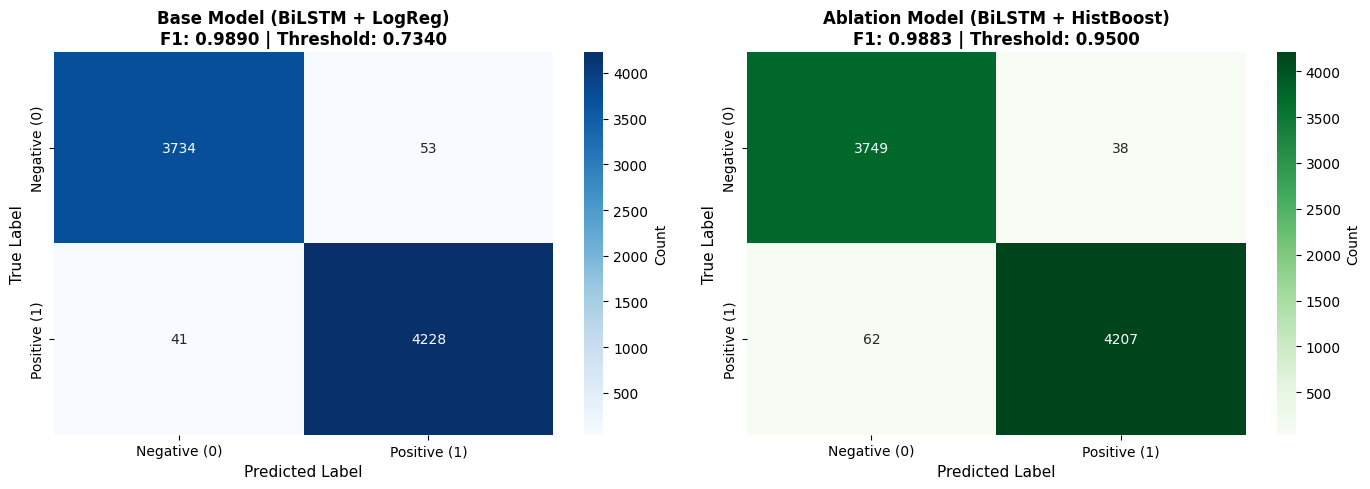

In [105]:
# CONFUSION MATRICES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Base Model Confusion Matrix
sns.heatmap(base_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            cbar_kws={'label': 'Count'})
axes[0].set_title(f'Base Model (BiLSTM + LogReg)\nF1: {base_f1:.4f} | Threshold: {best_thr:.4f}', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)
axes[0].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[0].set_yticklabels(['Negative (0)', 'Positive (1)'])

# Ablation Model Confusion Matrix
sns.heatmap(abl_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title(f'Ablation Model (BiLSTM + HistBoost)\nF1: {abl_f1:.4f} | Threshold: {val_thr:.4f}', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_xticklabels(['Negative (0)', 'Positive (1)'])
axes[1].set_yticklabels(['Negative (0)', 'Positive (1)'])

plt.tight_layout()
plt.show()

In [106]:
# ============================================
# DETAILED CLASSIFICATION REPORTS
# ============================================
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - BASE MODEL")
print("="*60)
print(classification_report(y_true_base, y_pred_base, 
                          target_names=['Negative (0)', 'Positive (1)'],
                          digits=4))

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT - ABLATION MODEL")
print("="*60)
print(classification_report(y_te, y_pred_abl, 
                          target_names=['Negative (0)', 'Positive (1)'],
                          digits=4))


DETAILED CLASSIFICATION REPORT - BASE MODEL
              precision    recall  f1-score   support

Negative (0)     0.9891    0.9860    0.9876      3787
Positive (1)     0.9876    0.9904    0.9890      4269

    accuracy                         0.9883      8056
   macro avg     0.9884    0.9882    0.9883      8056
weighted avg     0.9883    0.9883    0.9883      8056


DETAILED CLASSIFICATION REPORT - ABLATION MODEL
              precision    recall  f1-score   support

Negative (0)     0.9837    0.9900    0.9868      3787
Positive (1)     0.9910    0.9855    0.9883      4269

    accuracy                         0.9876      8056
   macro avg     0.9874    0.9877    0.9875      8056
weighted avg     0.9876    0.9876    0.9876      8056



In [107]:
# Misclassification analysis
print("\n" + "="*80)
print("BASE MODEL — MISCLASSIFICATION ANALYSIS")
print("="*80)

print("\nExamples of FALSE POSITIVES (legitimate marked as scam):")
fp_indices = np.where((y_pred_base == 1) & (y_true_base == 0))[0]
for i in fp_indices[:3]:
    print(f"\n{i}. Probability: {y_proba_base[i]:.3f}")
    print(f"Text: {test_df.iloc[i]['Body'][:200]}...")

print("\n" + "="*80)
print("ABLATION MODEL — MISCLASSIFICATION ANALYSIS")
print("="*80)

print("\nExamples of FALSE NEGATIVES (scam marked as legitimate):")
fn_indices = np.where((y_pred_base == 0) & (y_true_base == 1))[0]
for i in fn_indices[:3]:
    print(f"\n{i}. Probability: {y_proba_base[i]:.3f}")
    print(f"Text: {test_df.iloc[i]['Body'][:200]}...")


BASE MODEL — MISCLASSIFICATION ANALYSIS

Examples of FALSE POSITIVES (legitimate marked as scam):

50. Probability: 0.810
Text: gary conroy wybytbgwsnrealexpaymentscom dear merchants attached important information realex payments service announcements change address realex payments recently moved new offices new postal address...

481. Probability: 0.997
Text: newslettersbuyanowie multipart message mime format nextpartoo22a2colc2efo9o9t6oa2o contenttype textplain charsetiso88s9l contenttransferencoding quotedprintable back school buyanow dont feel lots spec...

489. Probability: 0.973
Text: hypermedia den geisteswissenschaften alle interessentinnen und interessenten von hypermedia anwendungen und entwicklungen der arbeitskreis hypermedia der gesellschaft fuer linguistische datenverarbeit...

ABLATION MODEL — MISCLASSIFICATION ANALYSIS

Examples of FALSE NEGATIVES (scam marked as legitimate):

616. Probability: 0.276
Text: gustavo neely buvhsaqplkdebrabuscom healthy development childre

## Step 4: Cross Domain Evaluation

### BiLSTM Base vs Ablation Mdel

In [108]:
# 1. LOAD CROSS-DOMAIN DATASET
print("\n" + "="*60)
print("LOADING CROSS-DOMAIN DATA")
print("="*60)

df = pd.read_csv(cd_path)

df = df.dropna(subset=["cleaned", "label"])
df["cleaned"] = df["cleaned"].astype(str).str.strip()
df = df[df["cleaned"] != ""]
df = df.reset_index(drop=True)

texts = df["cleaned"].tolist()
labels = df["label"].astype(int).tolist()

print(f"Loaded {len(df)} cleaned samples.")


# 2. DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 3. LOAD MANIFEST / META / RESOURCES
with open(os.path.join(best_dir_path, "manifest.json"), "r") as f:
    mf = json.load(f)


best_ckpt         = mf["best_ckpt"]
pad_id       = int(mf["pad_id"])
max_len      = int(mf["max_len"])
hidden_dim   = int(mf["hidden_dim"])
num_layers   = int(mf["num_layers"])
bidirectional= bool(mf["bidirectional"])
num_classes  = int(mf["num_classes"])
dropout      = float(mf["dropout"])
base_thr     = float(mf["val_threshold"])

# meta.json (ablation HistBoost threshold etc.)
with open(os.path.join(best_dir_path, "meta.json"), "r") as f:
    meta = json.load(f)

abl_thr   = float(meta["val_threshold"])
feat_dim  = int(meta["feat_dim"])

# embedding matrix
embedding_matrix = np.load(embed_matrix_path)

# SentencePiece tokenizer
sp = spm.SentencePieceProcessor()
sp.load(sp_model_path)


# 4. TOKENISE CROSS-DOMAIN TEXTS (SentencePiece + padding)
encoded = []
for t in texts:
    ids = sp.encode(t, out_type=int)
    if len(ids) < max_len:
        ids = ids + [pad_id] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    encoded.append(ids)

X = torch.tensor(encoded, dtype=torch.long)
y = torch.tensor(labels, dtype=torch.long)

cd_test_dataset = TensorDataset(X, y)
cd_test_dl = DataLoader(cd_test_dataset, batch_size=32, shuffle=False)



LOADING CROSS-DOMAIN DATA
Loaded 5092 cleaned samples.
Using device: cpu


In [110]:
# 5. LOAD BiLSTM MODEL (BASE) + ENCODER (for ablation)
print("\nLoading BiLSTM model...")

bilstm = BiLSTMClassifier(
    embedding_matrix=embedding_matrix,
    pad_id=pad_id,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
    bidirectional=bidirectional,
    num_classes=num_classes,
).to(device)

ckpt = torch.load(best_pt_path, map_location=device)
bilstm.load_state_dict(ckpt["model"], strict=True)
bilstm.eval()

encoder = bilstm.encoder
encoder.eval()

# 6. BASE MODEL EVALUATION (BiLSTM + internal classifier)
print("\n" + "="*60)
print("EVALUATING BASE MODEL (BiLSTM + LogReg HEAD)")
print("="*60)

all_probs_base = []
all_labels_base = []

with torch.no_grad():
    for xb, yb in cd_test_dl:
        xb = xb.to(device)
        logits = bilstm(xb)              # [B, 2]
        probs = F.softmax(logits, dim=1)[:, 1]  # p(class=1)
        all_probs_base.append(probs.cpu().numpy())
        all_labels_base.append(yb.numpy())

y_true_base  = np.concatenate(all_labels_base)
y_proba_base = np.concatenate(all_probs_base)
y_pred_base  = (y_proba_base >= base_thr).astype(int)

base_acc = accuracy_score(y_true_base, y_pred_base)
base_prec, base_rec, base_f1, _ = precision_recall_fscore_support(
    y_true_base, y_pred_base, average="binary"
)
base_auc = roc_auc_score(y_true_base, y_proba_base)
base_cm  = confusion_matrix(y_true_base, y_pred_base)

print(f"Base Model Results (Cross-Domain):")
print(f"  Accuracy : {base_acc:.4f}")
print(f"  Precision: {base_prec:.4f}")
print(f"  Recall   : {base_rec:.4f}")
print(f"  F1-Score : {base_f1:.4f}")
print(f"  ROC-AUC  : {base_auc:.4f}")
print(f"  Threshold: {base_thr:.4f}")


# 7. FEATURE EXTRACTION FOR ABLATION (using encoder)
@torch.no_grad()
def extract_features(encoder, loader, device):
    encoder.eval()
    feats, lbls = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        z  = encoder(xb)  # [B, feat_dim]
        feats.append(z.cpu().numpy().astype(np.float32))
        lbls.append(yb.numpy().astype(np.int64))
    return np.concatenate(feats), np.concatenate(lbls)

print("\nExtracting BiLSTM encoder features for ablation...")
X_feats, y_true_abl = extract_features(encoder, cd_test_dl, device)


# 8. LOAD HistBoost HEAD (Ablation) + EVALUATE
print("\n" + "="*60)
print("EVALUATING ABLATION MODEL (BiLSTM encoder + HistBoost)")
print("="*60)

hgb_path = os.path.join(best_dir_path, "model.pkl")
hgb = joblib.load(hgb_path)
print("HistBoost classifier head loaded.")

y_proba_abl = hgb.predict_proba(X_feats)[:, 1]
y_pred_abl  = (y_proba_abl >= abl_thr).astype(int)

abl_acc = accuracy_score(y_true_abl, y_pred_abl)
abl_prec, abl_rec, abl_f1, _ = precision_recall_fscore_support(
    y_true_abl, y_pred_abl, average="binary"
)
abl_auc = roc_auc_score(y_true_abl, y_proba_abl)
abl_cm  = confusion_matrix(y_true_abl, y_pred_abl)

print(f"Ablation Model Results (Cross-Domain):")
print(f"  Accuracy : {abl_acc:.4f}")
print(f"  Precision: {abl_prec:.4f}")
print(f"  Recall   : {abl_rec:.4f}")
print(f"  F1-Score : {abl_f1:.4f}")
print(f"  ROC-AUC  : {abl_auc:.4f}")
print(f"  Threshold: {abl_thr:.4f}")


# 9. MODEL COMPARISON TABLE
comparison = pd.DataFrame({
    "Model":    ["BiLSTM + LogReg (Base)", "BiLSTM + HistBoost (Ablation)"],
    "Accuracy": [base_acc, abl_acc],
    "Precision": [base_prec, abl_prec],
    "Recall":    [base_rec, abl_rec],
    "F1":        [base_f1, abl_f1],
    "ROC-AUC":   [base_auc, abl_auc],
})

print("\n" + "="*60)
print("MODEL COMPARISON (CROSS-DOMAIN)")
print("="*60)
pd.set_option("display.width", 50)    # small width forces wrapping
pd.set_option("display.max_colwidth", 20)
pd.set_option("display.max_columns", None)
print(comparison.to_string(index=False))


Loading BiLSTM model...


INFO:Features.encoding.bilstm_pipeline.biLSTM:BiLSTM Encoder initialized | emb_dim=300, hidden_dim=256, layers=2, bidirectional=True, freeze_embeddings=True



EVALUATING BASE MODEL (BiLSTM + LogReg HEAD)
Base Model Results (Cross-Domain):
  Accuracy : 0.5676
  Precision: 0.1863
  Recall   : 0.8003
  F1-Score : 0.3023
  ROC-AUC  : 0.7354
  Threshold: 0.7340

Extracting BiLSTM encoder features for ablation...

EVALUATING ABLATION MODEL (BiLSTM encoder + HistBoost)
HistBoost classifier head loaded.
Ablation Model Results (Cross-Domain):
  Accuracy : 0.7162
  Precision: 0.2400
  Recall   : 0.6577
  F1-Score : 0.3517
  ROC-AUC  : 0.7390
  Threshold: 0.9500

MODEL COMPARISON (CROSS-DOMAIN)
                        Model  Accuracy  Precision   Recall       F1  ROC-AUC
       BiLSTM + LogReg (Base)  0.567557   0.186328 0.800336 0.302281 0.735367
BiLSTM + HistBoost (Ablation)  0.716222   0.240049 0.657718 0.351727 0.738987


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to u


Base Model Confusion Matrix


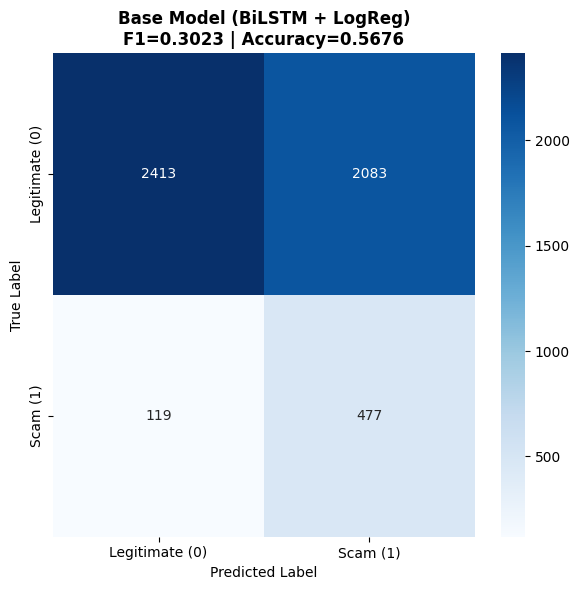


Ablation Model Confusion Matrix


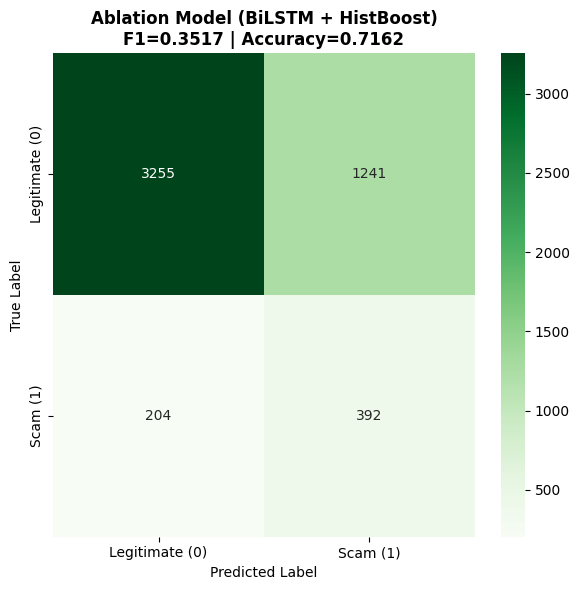

In [111]:
# 10. CONFUSION MATRICES
def plot_cm(cm, title, cmap):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=ax,
                xticklabels=['Legitimate (0)', 'Scam (1)'],
                yticklabels=['Legitimate (0)', 'Scam (1)'])
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()

print("\nBase Model Confusion Matrix")
plot_cm(
    base_cm,
    f"Base Model (BiLSTM + LogReg)\nF1={base_f1:.4f} | Accuracy={base_acc:.4f}",
    cmap="Blues"
)

print("\nAblation Model Confusion Matrix")
plot_cm(
    abl_cm,
    f"Ablation Model (BiLSTM + HistBoost)\nF1={abl_f1:.4f} | Accuracy={abl_acc:.4f}",
    cmap="Greens"
)

In [112]:

# 11. FALSE POSITIVES & FALSE NEGATIVES
def show_fp_fn_numpy_style(y_true, y_pred, y_proba, texts, label):
    print("\n" + "="*80)
    print(f"{label} — MISCLASSIFICATION ANALYSIS")
    print("="*80)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_proba = np.array(y_proba)

    # FP: predicted 1 (scam) but true 0 (legit)
    fp_indices = np.where((y_pred == 1) & (y_true == 0))[0]
    # FN: predicted 0 (legit) but true 1 (scam)
    fn_indices = np.where((y_pred == 0) & (y_true == 1))[0]

    print("\nExamples of FALSE POSITIVES (legitimate → scam):")
    if len(fp_indices) == 0:
        print("  None")
    else:
        for i in fp_indices[:3]:
            print(f"\n{i}. Probability (scam): {y_proba[i]:.3f}")
            print(f"Text: {texts[i][:200]}...")

    print("\nExamples of FALSE NEGATIVES (scam → legitimate):")
    if len(fn_indices) == 0:
        print("  None")
    else:
        for i in fn_indices[:3]:
            print(f"\n{i}. Probability (scam): {y_proba[i]:.3f}")
            print(f"Text: {texts[i][:200]}...")

# Base model FP/FN
show_fp_fn_numpy_style(
    y_true_base, y_pred_base, y_proba_base, texts,
    "BASE MODEL (BiLSTM + internal classifier head)"
)

# Ablation model FP/FN
show_fp_fn_numpy_style(
    y_true_abl, y_pred_abl, y_proba_abl, texts,
    "ABLATON MODEL (BiLSTM encoder + HistBoost)"
)


BASE MODEL (BiLSTM + internal classifier head) — MISCLASSIFICATION ANALYSIS

Examples of FALSE POSITIVES (legitimate → scam):

0. Probability (scam): 1.000
Text: go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat...

1. Probability (scam): 0.997
Text: ok lar joking wif u oni...

3. Probability (scam): 0.965
Text: u dun say so early hor u c already then say...

Examples of FALSE NEGATIVES (scam → legitimate):

5. Probability (scam): 0.087
Text: freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send to rcv...

15. Probability (scam): 0.273
Text: xxmobilemovieclub to use your credit click the wap link in the next txt message or click here>> <url> xxmobilemovieclubcomnqjkgighjjgcbl...

34. Probability (scam): 0.000
Text: thanks for your subscription to ringtone uk your mobile will be charged month please confirm by replying yes or no if you reply no you will not be ch